In [16]:
import pandas as pd
import numpy as np
from pqd_dataset import PQDDataset
from sklearn.utils.class_weight import compute_class_weight
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Adam
from tqdm.auto import tqdm, trange
from pqd_trainer import train_model, train_ae_model, evaluate_model, evaluate_ae_model, evaluate_npu_model
from models.conv_mlp import CONV_MLP
from models.conv_ae_mlp import CONV_AE_MLP
from sklearn.metrics import f1_score, balanced_accuracy_score
import random
import os

In [17]:
window_size = 32
stride = 1
target_mode = True
epochs=100
batch_size=32
lr = 0.0005

In [13]:
test_df = pd.read_csv('unlabeled.csv')
test_df['target'] = 0
test_df['target'][test_df['abnorm_evnt'] == 1] = 1
test_df['target'][test_df['emerg_evnt'] == 1] = 2

/tmp/ipykernel_23766/1012981628.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['target'][test_df['abnorm_evnt'] == 1] = 1
/tmp/ipykernel_23766/1012981628.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['target'][test_df['emerg_evnt'] == 1] = 2


In [19]:
model = torch.load('compare/2dcnn.pt')

In [27]:
ids = test_df.file_name.unique()

In [28]:
end_indices = []
for osc_id in tqdm(ids, desc="Creating window slices"):
    indices = np.array(test_df.index[test_df.file_name == osc_id])
    indices = indices[window_size:: stride]
    end_indices.extend(indices)

Creating window slices:   0%|          | 0/495 [00:00<?, ?it/s]

In [30]:
test_df['pred'] = 0

In [46]:
x_cols = ['IA', 'IC', 'UA BB', 'UB BB', 'UC BB']
model.eval()
for idx in tqdm(end_indices, desc="Creating window slices"):
    sample = test_df[x_cols].values[idx - window_size: idx]
    sample = torch.from_numpy(sample.astype("float32"))
    sample = sample.unsqueeze(0)
    sample = sample.permute(0, 2, 1)
    sample = sample.unsqueeze(2)
    pred = model(sample).argmax(axis=1)
    test_df['pred'].loc[idx] = pred.numpy()

Creating window slices:   0%|          | 0/330392 [00:00<?, ?it/s]

In [48]:
from sklearn.metrics import f1_score, balanced_accuracy_score

In [79]:
fault_files = []
for id in ids:
    pr = test_df.pred[test_df['file_name'] == id].unique()
    tg = test_df.target[test_df['file_name'] == id].unique()
    if 2 in set(tg):
        print('file name: ', id)
        print(pr)
        print(tg)
        fault_files.append(id)

file name:  0a4b53ee7134924f78336875854d74cd_Bus 2 _event N1
[0 1 2]
[1 2 0]
file name:  263035661c1e77f3a9afe26699cd8ddd_Bus 2 _event N1
[0 2]
[0 2]
file name:  3651d9f2468d63f4b8de9ed9502a9c32_Bus 2 _event N1
[0 2 1]
[0 1 2]
file name:  4e6415cbb51d616cafbfe48ad0949709_Bus 2 _event N1
[0 1 2]
[0 2]
file name:  524e846b63557e667fc44b3e8bcb5c8e_Bus 1 _event N1
[0 1 2]
[0 1 2]
file name:  524e846b63557e667fc44b3e8bcb5c8e_Bus 2 _event N1
[0 1 2]
[0 1 2]
file name:  61d08f6e61a9a4c44c716291ffb1a344_Bus 1 _event N1
[0]
[0 2]
file name:  61d08f6e61a9a4c44c716291ffb1a344_Bus 2 _event N1
[0 2]
[0 2]
file name:  855cfbb204abac136d3eb81a79e6de7d_Bus 1 _event N1
[0 1 2]
[1 2 0]
file name:  9349e7fc3aa633178fad634964c17b72_Bus 2 _event N1
[0 2]
[0 2]
file name:  aee4ab364963f1ef162f5bc577b1392c_Bus 1 _event N1
[0 1 2]
[0 1 2]
file name:  b18370f148f4f1c08ac3f3e494c4ed14_Bus 1 _event N1
[0]
[0 2]
file name:  b18370f148f4f1c08ac3f3e494c4ed14_Bus 2 _event N1
[0 2]
[0 2]
file name:  b418af421e4007a2b

<Axes: >

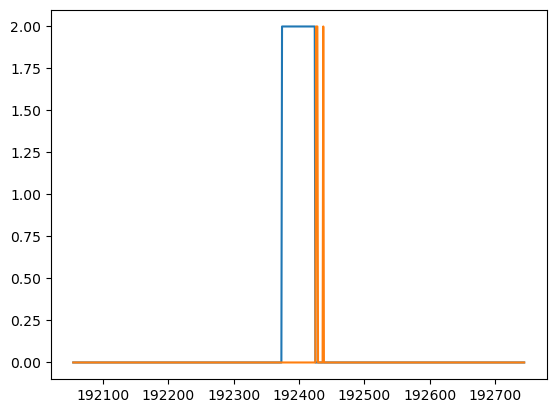

In [107]:
i = 9
test_df.target[test_df['file_name'] == fault_files[i]].plot()
test_df.pred[test_df['file_name'] == fault_files[i]].plot()